In [1]:
import os
import datetime
import argparse
import numpy as np
import cv2
import torch
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
from skimage import exposure 
from skimage import img_as_float64
import matplotlib.pyplot as plt

In [48]:
def singleScaleRetinex(img, sigma):

    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), sigma))

    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def colorRestoration(img, alpha, beta):

    img_sum = np.sum(img, axis=2, keepdims=True)

    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    return color_restoration

def simplestColorBalance(img, low_clip, high_clip):    

    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):            
            if float(current) / total < low_clip:
                low_val = u
            if float(current) / total < high_clip:
                high_val = u
            current += c
                
        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

    return img    

def MSRCR(img, sigma_list, G, b, alpha, beta, low_clip, high_clip):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)    
    img_color = colorRestoration(img, alpha, beta)    
    img_msrcr = G * (img_retinex * img_color + b)

    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                             (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                             255
    
    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr = simplestColorBalance(img_msrcr, low_clip, high_clip)       

    return img_msrcr

def automatedMSRCR(img, sigma_list):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break
            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break
            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255

    img_retinex = np.uint8(img_retinex)
        
    return img_retinex

def MSRCP(img, sigma_list, low_clip, high_clip):

    img = np.float64(img) + 1.0

    intensity = np.sum(img, axis=2) / img.shape[2]    

    retinex = multiScaleRetinex(intensity, sigma_list)

    intensity = np.expand_dims(intensity, 2)
    retinex = np.expand_dims(retinex, 2)

    intensity1 = simplestColorBalance(retinex, low_clip, high_clip)

    intensity1 = (intensity1 - np.min(intensity1)) / \
                 (np.max(intensity1) - np.min(intensity1)) * \
                 255.0 + 1.0

    img_msrcp = np.zeros_like(img)
    
    for y in range(img_msrcp.shape[0]):
        for x in range(img_msrcp.shape[1]):
            B = np.max(img[y, x])
            A = np.minimum(256.0 / B, intensity1[y, x, 0] / intensity[y, x, 0])
            img_msrcp[y, x, 0] = A * img[y, x, 0]
            img_msrcp[y, x, 1] = A * img[y, x, 1]
            img_msrcp[y, x, 2] = A * img[y, x, 2]

    img_msrcp = np.uint8(img_msrcp - 1.0)

    return img_msrcp

In [53]:
def retinex_alg(image):
  SIGMA_LIST = [15, 80, 250]
  ALPHA = 125.0
  BETA = 46.0
  G = 5.0
  OFFSET = 25.0 
  low_clip = 0.01
  high_clip = 0.99
  return  automatedMSRCR(image, SIGMA_LIST)

In [54]:
def color_correction(image, hazy_image, gamma = 1.2):
  out = np.zeros_like(image)

  blue = image[:, :, 0].astype(np.float) / 255
  green = image[:, :, 1].astype(np.float) / 255
  red = image[:, :, 2].astype(np.float) / 255

  hazy_blue = hazy_image[:, :, 0].astype(np.float) / 255
  hazy_green = hazy_image[:, :, 1].astype(np.float) / 255
  hazy_red = hazy_image[:, :, 2].astype(np.float) / 255

  out_red = np.power((hazy_red ) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (red)
  out_green = np.power((hazy_green) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (green)
  out_blue = np.power((hazy_blue) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (blue)

  out = np.clip(np.dstack([out_blue[:, :, np.newaxis], out_green[:, :, np.newaxis], out_red[:, :, np.newaxis]]), 0, 1) * 255
  return out.astype(np.uint8)

In [55]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    # https://en.wikipedia.org/wiki/Unsharp_masking
  
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [56]:
def alpha_sum(image1, image2, alpha=0.3):
    image = alpha*image1 + (1 - alpha)*image2
    return np.clip(image, 0, 255).astype(np.uint8)

In [57]:
def imshow3(img1, img2, img3, size=12, cmap='jet'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.imshow(img1)
    #ax1.set_title(lbl1, fontsize=20)
    ax1.axis('off')

    ax2.imshow(img2)
    #ax2.set_title(lbl2, fontsize=20)
    ax2.axis('off')

    ax3.imshow(img3)
    #ax3.set_title(lbl3, fontsize=20)
    ax3.axis('off')
    fig.tight_layout()
    plt.show()

In [70]:
hazy_folder = '/home/franz/RTTS/RTTS/JPEGImages'
dehazed_folder = '/home/franz/RTTS/ds/dehazed/JPEGImages'
out_folder = '/home/franz/RTTS/ds/enhanced_retinex/JPEGImages'

In [71]:
def merecover(filepath, gamma=1.4, alpha=0.3, use_retinex=True, use_alpha_sum=True, use_color_correction=True, use_exposure=True, exposure_weight=0.5, use_unsharp_mask=True):
  hazy_image = cv2.imread(os.path.join(hazy_folder, os.path.basename(filepath)))
  dehazed_image = cv2.imread(os.path.join(dehazed_folder, os.path.basename(filepath)))
  #dehazed_image = cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR) # BGR


  if (hazy_image.shape[0] != dehazed_image.shape[0]) or (hazy_image.shape[1] != dehazed_image.shape[1]):
    h, w = hazy_image.shape[:2]
    dehazed_image = cv2.resize(dehazed_image, (w, h))
  
  result = dehazed_image.copy() # BGR

  if use_retinex:
    result = retinex_alg(result) # BGR
    if use_alpha_sum:
      result = alpha_sum(result, dehazed_image, alpha=alpha)
#   if use_color_correction:
#     result = color_correction(result, hazy_image, gamma=gamma)
    if use_exposure:
      result = (exposure_weight * result.astype(np.float) + (1 - exposure_weight)*(exposure.equalize_hist(result)*255)).astype(np.uint8)
    if use_unsharp_mask:
      result = unsharp_mask(result)
  return dehazed_image, result

In [72]:
before = None

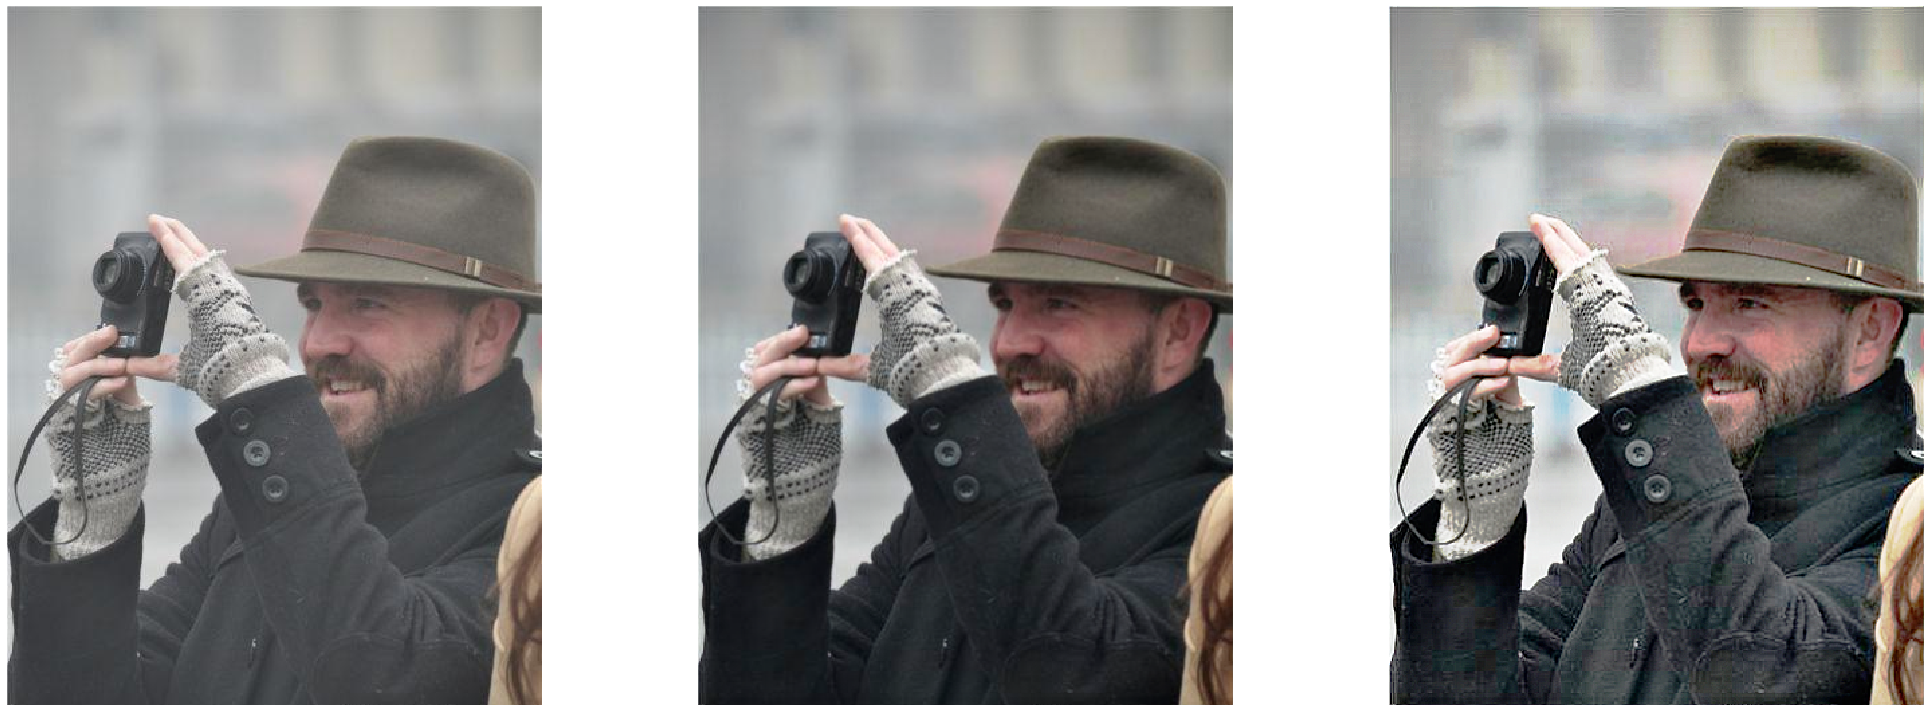

In [73]:
filepath = "rtts_coco/JPEGImages/HEB_Google_618.png" #@param ['rtts_coco/JPEGImages/HEB_Google_618.png', 'rtts_coco/JPEGImages/WST_Bing_521.png', 'rtts_coco/JPEGImages/BJ_Baidu_748.png', 'rtts_coco/JPEGImages/SY_Google_321.png', 'rtts_coco/JPEGImages/JL_Baidu_057.png', 'rtts_coco/JPEGImages/JL_Google_674.png', 'rtts_coco/JPEGImages/SH_Google_161.png', 'rtts_coco/JPEGImages/QD_Baidu_169.png', 'rtts_coco/JPEGImages/SY_Google_44.png', 'rtts_coco/JPEGImages/MLS_Bing_108.png', 'rtts_coco/JPEGImages/GSGL_Baidu_607.png', 'rtts_coco/JPEGImages/hv42_675.png', 'rtts_coco/JPEGImages/BL_Baidu_213.png', 'rtts_coco/JPEGImages/hv30_145.png', 'rtts_coco/JPEGImages/HEB_Baidu_432.png', 'rtts_coco/JPEGImages/hv42_6.png', 'rtts_coco/JPEGImages/hv17_44.png', 'rtts_coco/JPEGImages/GSGL_Google_396.png', 'rtts_coco/JPEGImages/DJ_Baidu_189.png', 'rtts_coco/JPEGImages/SJZ_Bing_587.png', 'rtts_coco/JPEGImages/KRO_Google_036.png', 'rtts_coco/JPEGImages/GSGL_Bing_122.png', 'rtts_coco/JPEGImages/GSGL_Baidu_148.png', 'rtts_coco/JPEGImages/hv37_1088.png', 'rtts_coco/JPEGImages/BJ_Bing_419.png', 'rtts_coco/JPEGImages/TJ_Baidu_232.png', 'rtts_coco/JPEGImages/HF_Baidu_358.png', 'rtts_coco/JPEGImages/hv19_225.png', 'rtts_coco/JPEGImages/XR_Baidu_164.png', 'rtts_coco/JPEGImages/XG_Baidu_548.png', 'rtts_coco/JPEGImages/HEB_Bing_437.png', 'rtts_coco/JPEGImages/LSJ_Baidu_946.png', 'rtts_coco/JPEGImages/hv9_221.png', 'rtts_coco/JPEGImages/hv50_304.png', 'rtts_coco/JPEGImages/XR_Bing_756.png', 'rtts_coco/JPEGImages/HazeDr_Google_802.png', 'rtts_coco/JPEGImages/hv11_549.png', 'rtts_coco/JPEGImages/TJ_Baidu_583.png', 'rtts_coco/JPEGImages/SJZ_Bing_082.png', 'rtts_coco/JPEGImages/HF_Bing_737.png', 'rtts_coco/JPEGImages/BD_Baidu_134.png', 'rtts_coco/JPEGImages/LZ_Baidu_221.png', 'rtts_coco/JPEGImages/hv4_308.png', 'rtts_coco/JPEGImages/hv30_128.png', 'rtts_coco/JPEGImages/hv37_523.png', 'rtts_coco/JPEGImages/hv39_684.png', 'rtts_coco/JPEGImages/GSGL_Baidu_360.png', 'rtts_coco/JPEGImages/LZ_Bing_111.png', 'rtts_coco/JPEGImages/IRQ_Bing_005.png', 'rtts_coco/JPEGImages/hv6_204.png']

gamma = 1.04 #@param {type:"slider", min:0, max:3, step:0.01}

alpha = 0.3 #@param {type: "slider", min:0, max: 1, step: 0.01}

use_retinex = True #@param {type: "boolean"}

use_alpha_sum = True #@param {type: "boolean"}

use_color_correction = False #@param {type: "boolean"}

use_exposure = True #@param {type: "boolean"}

exposure_weight=0.5 #@param {type: "slider", min:0, max:1, step: 0.01}

use_unsharp_mask=True #@param {type: "boolean"}


hazy_image = cv2.imread(os.path.join(hazy_folder, os.path.basename(filepath)))
dehazed_image, result = merecover(os.path.join(dehazed_folder, os.path.basename(filepath)), gamma, alpha, use_retinex, use_alpha_sum, use_color_correction, use_exposure, exposure_weight, use_unsharp_mask)

input_rgb   = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2RGB)
dehazed_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

imshow3(input_rgb, dehazed_rgb, result_rgb)
if not before is None:
  imshow3(input_rgb, dehazed_rgb, result_rgb)

before = result_rgb

In [68]:
!mkdir -p {out_folder}

In [74]:
for filepath in glob('/home/franz/RTTS/ds/dehazed/JPEGImages/*.png'):
  dehazed_image, result = merecover(filepath, gamma, alpha, use_retinex, use_alpha_sum, use_color_correction, use_exposure, exposure_weight, use_unsharp_mask)
  cv2.imwrite(os.path.join(out_folder, os.path.basename(filepath)), result)